# Momentum distributions

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ May 30, 2023

Plots momentum distributions focusing on scale and scheme dependence.
Single-nucleon and pair momentum distributions are calculated using SRG-evolved momentum projection operators with low-resolution nuclear wavefunctions approximated as a single Slater determinant of Woods-Saxon single-particle orbitals. 

_Last update:_ August 8, 2023

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.interpolate import RectBivariateSpline

In [2]:
# Imports from scripts
from scripts.figures import (
    label_kvnn, label_lambda, label_nucleus, set_rc_parameters
)
from scripts.tools import replace_periods

from test_momentum_distribution_script import load_momentum_distribution
from test_momentum_distribution_script import compute_normalization as snmd_norm
from test_pmd_script_v1 import load_pmd as load_pmd_v1
from test_pmd_script import load_pmd
from test_pmd_script import compute_normalization as pmd_norm
from test_pmd_Q0 import load_Q0_pmd

## Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

In [4]:
# Save figures in the following directory
figures_directory = '../figures/momentum_distributions/'
vmc_directory = '../data/vmc/momentum_distributions/'

## Single-nucleon momentum distributions

In [ ]:
def single_nucleon_momentum_distribution(
        nucleus_name, nucleon, kvnn, lamb, error_bars=False, x_limits=(0.0,6.0),
        y_limits=(9e-6,1e3), y_scale='log', show_vmc=False, save=False
):
    """Plot a single-nucleon momentum distribution with several built-in
    options.
    """
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
        
    # Compare to VMC calculation?
    if show_vmc:
        
        file_name = f"{nucleus_name}_single_nucleon.txt"
        data = np.loadtxt(vmc_directory + file_name)
        q_array_vmc = data[:,0]
        n_array_vmc = data[:,1]
        n_errors_vmc = data[:,2]
        
        if y_scale == 'linear':
            
            ax.errorbar(
                q_array_vmc, n_array_vmc * q_array_vmc **2 , yerr=n_errors_vmc,
                color='black', label='VMC', linestyle='', marker='.', zorder=3
            )
            
        else:
            
            ax.errorbar(
                q_array_vmc, n_array_vmc, yerr=n_errors_vmc, color='black',
                label='VMC', linestyle='', marker='.', zorder=3
            )

    # Load data from file
    q_array, q_weights, n_array, n_errors, n_ipm_array, _, _, _, _ = (
        load_momentum_distribution(nucleus_name, nucleon, kvnn, lamb)
    )
    
    # Multiply by factor (2\pi)^3 to compare to VMC data
    n_array *= (2*np.pi) ** 3
    n_errors *= (2*np.pi) ** 3
    n_ipm_array *= (2*np.pi) ** 3

    # Add to plot
    if y_scale == 'linear':
        
        if error_bars:
            
            ax.errorbar(
                q_array, n_array * q_array ** 2, yerr=n_errors, label='SRG',
                linestyle='solid', linewidth=2.0, zorder=2
            )
    
        else:
            
            ax.plot(q_array, n_array * q_array ** 2, label='SRG', linewidth=2.0,
                    zorder=2)
            
        ax.plot(q_array, n_ipm_array * q_array ** 2, label='IPM',
                linestyle='dotted', linewidth=2.0, zorder=1)

    else:
        
        if error_bars:
            
            ax.errorbar(
                q_array, n_array, yerr=n_errors, label='SRG', linestyle='solid',
                linewidth=2.0, zorder=2
            )
    
        else:
            
            ax.plot(q_array, n_array, label='SRG', linewidth=2.0, zorder=2)
            
        ax.plot(q_array, n_ipm_array, label='IPM', linestyle='dotted',
                linewidth=2.0, zorder=1)

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    if y_scale == 'linear' and nucleon == 'proton':
        ylabel = r"$q^2 n_{p}(q)$ [fm]"
    elif y_scale == 'linear' and nucleon == 'neutron':
        ylabel = r"$q^2 n_{n}(q)$ [fm]"
    elif y_scale == 'log' and nucleon == 'proton':
        ylabel = r"$n_{p}(q)$ [fm" + r'$^3$' + ']'
    elif y_scale == 'log' and nucleon == 'neutron':
        ylabel = r"$n_{n}(q)$ [fm" + r'$^3$' + ']'
    ax.set_ylabel(ylabel, fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Add \lambda label as title (for now)
    ax.set_title(label_lambda(lamb), fontsize=14)
    
    # Save?
    if save:
        file_name = replace_periods(
            f"{nucleus_name}_{nucleon}_momentum_distribution_kvnn_{kvnn}"
            f"_lamb_{lamb}_{y_scale}_scale"
        )
        f.savefig(figures_directory + file_name + '.png')

In [ ]:
def single_nucleon_momentum_distributions_multipanel(
        nuclei, nucleon, kvnn, lamb, x_limits=(0.0,6.0), y_limits=(1e-4,1e3),
        y_scale='log', show_vmc=False, save=False
):
    """Plot a single-nucleon momentum distribution with several built-in
    options.
    """
    
    # Initialize figure
    plt.close('all')
    row_number, col_number = 1, len(nuclei)
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True,
                          figsize=(4*col_number, 4*row_number))
        
    # Loop over nuclei
    for i, nucleus in enumerate(nuclei):
        
        nucleus_name, Z, N = nucleus
        if nucleon == 'proton':
            factor = Z
        elif nucleon == 'neutron':
            factor = N
            
        if y_scale == 'log':
            axs[i].set_yscale('log')
        else:
            axs[i].set_yscale('linear')
        
        # Compare to VMC calculation?
        if show_vmc:
        
            file_name = f"{nucleus_name}_single_nucleon.txt"
            data = np.loadtxt(vmc_directory + file_name)
            q_array_vmc = data[:,0]
            n_array_vmc = data[:,1] / factor
            n_errors_vmc = data[:,2] / factor
        
            if y_scale == 'linear':
            
                axs[i].errorbar(
                    q_array_vmc, n_array_vmc * q_array_vmc **2 ,
                    yerr=n_errors_vmc, color='black', label='VMC', linestyle='',
                    marker='.', zorder=3
                )
            
            else:
            
                axs[i].errorbar(
                    q_array_vmc, n_array_vmc, yerr=n_errors_vmc, color='black',
                    label='VMC', linestyle='', marker='.', zorder=3
                )

        # Load data from file
        q_array, q_weights, n_array, n_errors, n_ipm_array, _, _, _, _ = (
            load_momentum_distribution(nucleus_name, nucleon, kvnn, lamb)
        )
    
        # Multiply by factor (2\pi)^3 / Z (N) to compare to VMC data
        n_array *= (2*np.pi) ** 3 / factor
        n_errors *= (2*np.pi) ** 3 / factor
        n_ipm_array *= (2*np.pi) ** 3 / factor

        # Add to plot
        if y_scale == 'linear':
        
            axs[i].plot(
                q_array, n_array * q_array ** 2,
                label='SRG', linewidth=2.0, zorder=2
            )
            
            axs[i].plot(q_array, n_ipm_array * q_array ** 2, label='IPM',
                        linestyle='dotted', linewidth=2.0, zorder=1)

        else:
        
            axs[i].plot(q_array, n_array, label='SRG', linewidth=2.0, zorder=2)
            
            axs[i].plot(q_array, n_ipm_array, label='IPM', linestyle='dotted',
                        linewidth=2.0, zorder=1)

        # Set axes limits
        axs[i].set_xlim(x_limits)
        axs[i].set_ylim(y_limits)

        # Set axes labels
        axs[i].set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
        if i == 0:  # First column only
            if y_scale == 'linear' and nucleon == 'proton':
                ylabel = r"$q^2 n_{p}(q)/Z$ [fm]"
            elif y_scale == 'linear' and nucleon == 'neutron':
                ylabel = r"$q^2 n_{n}(q)/N$ [fm]"
            elif y_scale == 'log' and nucleon == 'proton':
                ylabel = r"$n_{p}(q)/Z$ [fm" + r'$^3$' + ']'
            elif y_scale == 'log' and nucleon == 'neutron':
                ylabel = r"$n_{n}(q)/N$ [fm" + r'$^3$' + ']'
            axs[i].set_ylabel(ylabel, fontsize=16)

        # Set legend
        axs[i].legend(loc='upper right', fontsize=16, frameon=False)

        # Add nucleus label
        if y_scale == 'log':
            nucleus_label_loc = 'lower left'
        elif y_scale == 'linear':
            nucleus_label_loc = 'upper left'
        axs[i].add_artist(
            AnchoredText(label_nucleus(nucleus_name), loc=nucleus_label_loc,
                         prop=dict(size=22), frameon=False)
        )
        
    # Amount of white space in-between sub-plots
    f.subplots_adjust(wspace=0.1)

    # Save?
    if save:   
        file_name = replace_periods(
            f"{nucleon}_momentum_distributions_kvnn_{kvnn}_lamb_{lamb}"
            f"_{y_scale}_scale"
        )
        f.savefig(figures_directory + file_name + '.png')

In [ ]:
def single_nucleon_momentum_distribution_contributions(
        nucleus_name, nucleon, kvnn, lamb, number_of_curves=4,
        x_limits=(0.0,6.0), y_limits=(9e-6,1e3), print_normalization=False,
        save=False
):
    """Plots momentum distributions showing I, \delta U + \delta U^\dagger, and
    \delta U \delta U^\dagger contributions.
    """
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))

    # Load data from file
    (q_array, q_weights, n_array, _, n_I_array, n_delU_array, _, n_delU2_array,
     _) = load_momentum_distribution(nucleus_name, nucleon, kvnn, lamb)
    
    # Print normalization?
    if print_normalization:

        total_norm = snmd_norm(q_array, q_weights, n_array)
        print(f"Total normalization = {total_norm}.")
        
        I_norm = snmd_norm(q_array, q_weights, n_I_array)
        print(f"I normalization = {I_norm}.")
        
        delU_norm = snmd_norm(q_array, q_weights, n_delU_array)
        print(f"\delta U + \delta U^\dagger normalization = {delU_norm}.")
        
        delU2_norm = snmd_norm(q_array, q_weights, n_delU2_array)
        print(f"\delta U \delta U^\dagger normalization = {delU2_norm}.")
        
        relative_error = np.abs(delU_norm + delU2_norm) / delU2_norm * 100
        print(f"Relative error = {relative_error}%.")
    
    # Multiply by factor (2\pi)^3
    n_array *= (2*np.pi) ** 3
    n_I_array *= (2*np.pi) ** 3
    n_delU_array *= (2*np.pi) ** 3
    n_delU2_array *= (2*np.pi) ** 3

    # Add to plot
    ax.semilogy(q_array, n_array, color='black', label='Total', linewidth=2.0,
                zorder=1)
    if number_of_curves > 1:
        ax.semilogy(q_array, n_I_array, color='blue', label='I',
                    linestyle='dotted', linewidth=2.0, zorder=2)
    if number_of_curves > 2:
        ax.semilogy(
            q_array, np.abs(n_delU_array), color='green',
            label=r'$|\delta U+\delta U^\dagger|$', linestyle='dashed',
            linewidth=2.0, zorder=3
        )
    if number_of_curves > 3:
        ax.semilogy(
            q_array, n_delU2_array, color='red',
            label=r'$\delta U \delta U^\dagger$', linestyle='dashdot',
            linewidth=2.0, zorder=4
        )
    
    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    if nucleon == 'proton':
        ylabel = r"$n_{p}(q)$ [fm" + r'$^3$' + ']'
    elif nucleon == 'neutron':
        ylabel = r"$n_{n}(q)$ [fm" + r'$^3$' + ']'
    ax.set_ylabel(ylabel, fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Add \lambda label as title (for now)
    ax.set_title(label_lambda(lamb), fontsize=14)
    
    # Save?
    if save:
        if number_of_curves >= 4:
            file_name = replace_periods(
                f"{nucleus_name}_{nucleon}_momentum_distribution_contributions"
                f"_kvnn_{kvnn}_lamb_{lamb}"
            )
        else:
            file_name = replace_periods(
                f"{nucleus_name}_{nucleon}_momentum_distribution_contributions"
                f"_kvnn_{kvnn}_lamb_{lamb}_{number_of_curves}"
            )
        f.savefig(figures_directory + file_name + ".png")

In [ ]:
def single_nucleon_momentum_distributions_vary_nucleus(
        nuclei, nucleon, kvnn, lamb, x_limits=(0.0,6.0), y_limits=(1e-4,1e3),
        y_scale='log', kvnn_label_location='lower left',
        legend_fontsize=14, save=False
):
    """Plots momentum distributions varying the NN potential."""
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
    
    # Loop over potentials
    for i, nucleus in enumerate(nuclei):
        
        nucleus_name, Z, N = nucleus

        # Load data from file
        (q_array, q_weights, n_array, _, _, _, _, _, _) = (
            load_momentum_distribution(nucleus_name, nucleon, kvnn, lamb)
        )
    
        # Multiply by factor (2\pi)^3 / Z
        if nucleon == 'proton':
            n_array *= (2*np.pi) ** 3 / Z
        elif nucleon == 'neutron':
            n_array *= (2*np.pi) ** 3 / N

        # Add to plot
        if y_scale == 'linear':  # Linear scale
            ax.plot(q_array, n_array * q_array ** 2,
                    label=label_nucleus(nucleus_name), linewidth=1.5)
        elif y_scale == 'log':  # Log scale
            ax.plot(q_array, n_array, label=label_nucleus(nucleus_name),
                    linewidth=1.5)

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    if y_scale == 'linear' and nucleon == 'proton':
        ylabel = r"$q^2 n_{p}(q)/Z$ [fm]"
    elif y_scale == 'linear' and nucleon == 'neutron':
        ylabel = r"$q^2 n_{n}(q)/N$ [fm]"
    elif y_scale == 'log' and nucleon == 'proton':
        ylabel = r"$n_{p}(q)/Z$ [fm" + r'$^3$' + ']'
    elif y_scale == 'log' and nucleon == 'neutron':
        ylabel = r"$n_{n}(q)/N$ [fm" + r'$^3$' + ']'
    ax.set_ylabel(ylabel, fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=legend_fontsize, frameon=False)

    # Add kvnn label
    ax.add_artist(
        AnchoredText(label_kvnn(kvnn), loc=kvnn_label_location,
                     prop=dict(size=18), frameon=False)
    )
    
    # Add \lambda label as title (for now)
    ax.set_title(label_lambda(lamb), fontsize=14)
    
    # Save?
    if save:
        file_name = (f"{nucleon}_momentum_distributions_kvnn_{kvnn}_lamb_{lamb}"
                     f"_{y_scale}_scale")
        for nucleus in nuclei:
            nucleus_name, _, _ = nucleus
            file_name += f"_{nucleus_name}"
        file_name = replace_periods(file_name)
        f.savefig(figures_directory + file_name + ".png")

In [ ]:
def single_nucleon_momentum_distributions_vary_kvnn(
        nucleus_name, nucleon, kvnns, lamb, x_limits=(0.0,6.0),
        y_limits=(9e-6,1e3), y_scale='log', nucleus_label_location='lower left',
        legend_fontsize=11, save=False
):
    """Plots momentum distributions varying the NN potential."""
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
    
    # Loop over potentials
    for i, kvnn in enumerate(kvnns):
        
        # Load data from file
        (q_array, q_weights, n_array, _, _, _, _, _, _) = (
            load_momentum_distribution(nucleus_name, nucleon, kvnn, lamb)
        )
    
        # Multiply by factor (2\pi)^3
        n_array *= (2*np.pi) ** 3

        # Add to plot
        if y_scale == 'linear':  # Linear scale
            ax.plot(q_array, n_array * q_array ** 2, label=label_kvnn(kvnn),
                    linewidth=1.5)
        elif y_scale == 'log':  # Log scale
            ax.plot(q_array, n_array, label=label_kvnn(kvnn), linewidth=1.5)

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    if y_scale == 'linear' and nucleon == 'proton':
        ylabel = r"$q^2 n_{p}(q)$ [fm]"
    elif y_scale == 'linear' and nucleon == 'neutron':
        ylabel = r"$q^2 n_{n}(q)$ [fm]"
    elif y_scale == 'log' and nucleon == 'proton':
        ylabel = r"$n_{p}(q)$ [fm" + r'$^3$' + ']'
    elif y_scale == 'log' and nucleon == 'neutron':
        ylabel = r"$n_{n}(q)$ [fm" + r'$^3$' + ']'
    ax.set_ylabel(ylabel, fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=legend_fontsize, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc=nucleus_label_location,
                     prop=dict(size=18), frameon=False)
    )
    
    # Add \lambda label as title (for now)
    ax.set_title(label_lambda(lamb), fontsize=14)
    
    # Save?
    if save:
        file_name = f"{nucleus_name}_{nucleon}_momentum_distributions_kvnns"
        for kvnn in kvnns:
            file_name += f"_{kvnn}"
        file_name += f"_lamb_{lamb}_{y_scale}_scale"
        file_name = replace_periods(file_name)
        f.savefig(figures_directory + file_name + ".png")

In [ ]:
def single_nucleon_momentum_distributions_vary_lambda(
        nucleus_name, nucleon, kvnn, lambdas, x_limits=(0.0,6.0),
        y_limits=(9e-6,1e3), y_scale='log', nucleus_label_location='lower left',
        legend_fontsize=11, save=False
):
    """Plots momentum distributions varying the SRG flow parameter \lambda."""
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
    
    # Loop over \lambda
    for i, lamb in enumerate(lambdas):
        
        # Load data from file
        (q_array, q_weights, n_array, _, n_ipm_array, _, _, _, _) = (
            load_momentum_distribution(nucleus_name, nucleon, kvnn, lamb)
        )
    
        # Multiply by factor (2\pi)^3
        n_array *= (2*np.pi) ** 3
        
        # Plot the IPM (\lambda=\infinity) result once
        if i == 0:
            n_ipm_array *= (2*np.pi) ** 3
            
            if y_scale == 'linear':  # Linear scale
                
                ax.plot(
                    q_array, n_ipm_array * q_array ** 2,
                    label=label_lambda(np.inf), color='black',
                    linestyle='dotted', linewidth=1.5
                )
            
            elif y_scale == 'log':  # Log scale
                
                ax.plot(q_array, n_ipm_array, label=label_lambda(np.inf),
                        color='black', linestyle='dotted', linewidth=1.5)

        # Add to plot
        if y_scale == 'linear':
            
            ax.plot(q_array, n_array * q_array ** 2, alpha=(i+1)/len(lambdas),
                    color='red', label=label_lambda(lamb), linewidth=1.5)
            
        elif y_scale == 'log':
            
            ax.plot(q_array, n_array, alpha=(i+1)/len(lambdas), color='red',
                    label=label_lambda(lamb), linewidth=1.5)

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    if y_scale == 'linear' and nucleon == 'proton':
        ylabel = r"$q^2 n_{p}(q)$ [fm]"
    elif y_scale == 'linear' and nucleon == 'neutron':
        ylabel = r"$q^2 n_{n}(q)$ [fm]"
    elif y_scale == 'log' and nucleon == 'proton':
        ylabel = r"$n_{p}(q)$ [fm" + r'$^3$' + ']'
    elif y_scale == 'log' and nucleon == 'neutron':
        ylabel = r"$n_{n}(q)$ [fm" + r'$^3$' + ']'
    ax.set_ylabel(ylabel, fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=legend_fontsize, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc=nucleus_label_location,
                     prop=dict(size=18), frameon=False)
    )
    
    # Save?
    if save:
        file_name = (f"{nucleus_name}_{nucleon}_momentum_distributions_kvnn"
                     f"_{kvnn}_lambdas")
        for lamb in lambdas:
            file_name += f"_{lamb}"
        file_name += f"_{y_scale}_scale"
        file_name = replace_periods(file_name)
        f.savefig(figures_directory + file_name + ".png")

### Proton momentum distributions for several nuclei

In [ ]:
# \lambda = 1.5 fm^-1

nuclei = (('He4', 2, 2), ('C12', 6, 6), ('O16', 8, 8), ('Ca40', 20, 20))

single_nucleon_momentum_distributions_multipanel(
    nuclei, 'proton', 6, 1.5, y_limits=(1e-4, 5e2), show_vmc=True, save=True
)

In [ ]:
# \lambda = 1.5 fm^-1

nuclei = (('He4', 2, 2), ('C12', 6, 6), ('O16', 8, 8), ('Ca40', 20, 20))

single_nucleon_momentum_distributions_multipanel(
    nuclei, 'proton', 6, 1.5, x_limits=(0.0, 2.0), y_limits=(-0.1, 30),
    y_scale='linear', show_vmc=True, save=True
)

In [ ]:
single_nucleon_momentum_distribution_contributions(
    'He4', 'proton', 6, 1.5, y_limits=(1e-4, 1e3), print_normalization=True,
    save=True
)

In [ ]:
single_nucleon_momentum_distribution_contributions(
    'C12', 'proton', 6, 1.5, y_limits=(1e-3, 1e3), print_normalization=True,
    save=True
)

In [ ]:
single_nucleon_momentum_distribution_contributions(
    'O16', 'proton', 6, 1.5, y_limits=(1e-3, 1e3), print_normalization=True,
    save=True
)

In [ ]:
single_nucleon_momentum_distribution_contributions(
    'Ca40', 'proton', 6, 1.5, y_limits=(1e-3, 8e3), print_normalization=True,
    save=True
)

In [ ]:
single_nucleon_momentum_distribution_contributions(
    'Ca48', 'proton', 6, 1.5, y_limits=(1e-3, 8e3), print_normalization=True,
    save=True
)

In [ ]:
single_nucleon_momentum_distribution_contributions(
    'Ca48', 'neutron', 6, 1.5, y_limits=(1e-3, 8e3), print_normalization=True,
    save=True
)

### Comparing different nuclei

In [ ]:
nuclei = (('He4', 2, 2), ('C12', 6, 6), ('O16', 8, 8), ('Ca40', 20, 20),
          ('Ca48', 20, 28), ('Pb208', 82, 126))

single_nucleon_momentum_distributions_vary_nucleus(
    nuclei, 'proton', 6, 1.5, y_limits=(1e-4, 5e2), save=True)

### Comparing different interactions

In [ ]:
single_nucleon_momentum_distributions_vary_kvnn(
    'O16', 'proton', (5, 6, 7, 79, 111, 222), 1.5, y_limits=(1e-3,1e3),
    save=True
)

In [ ]:
single_nucleon_momentum_distributions_vary_kvnn(
    'O16', 'proton', (5, 6, 7, 79, 111, 222), 1.5, x_limits=(0.0, 2.0),
    y_limits=(-0.1, 210.0), y_scale='linear',
    nucleus_label_location='upper left', legend_fontsize=8, save=True
)

### Comparing different $\lambda$ values

In [ ]:
single_nucleon_momentum_distributions_vary_lambda(
    'O16', 'proton', 6, (6.0, 3.0, 2.0, 1.7, 1.5, 1.35), y_limits=(1e-3, 1e3),
    save=True
)

In [ ]:
single_nucleon_momentum_distributions_vary_lambda(
    'O16', 'proton', 6, (6.0, 3.0, 2.0, 1.7, 1.5, 1.35), x_limits=(0.0, 2.0),
    y_limits=(-0.1, 210.0), y_scale='linear',
    nucleus_label_location='upper left', legend_fontsize=9, save=True
)

## Pair momentum distributions

In [ ]:
def load_vmc_pair_qQ(nucleus_name, Q):
    """Gets the n(q,Q) VMC data."""
    
    q_size = len(np.arange(0.1, 6.1, 0.1)) + 1
    data = np.zeros((q_size, 5))
    
    directory = "../data/vmc/momentum_distributions/"
    file_name = f"{nucleus_name}_pair_qQ.txt"
    
    f = open(directory + file_name, 'r')
    
    i = 0
    flag = False
    for line in f:
        
        unit = line.strip().split()
        
        if len(unit) > 0 and unit[0] == "QQ(J)" and float(unit[2]) == Q:

            flag = True
            
        if flag:
            
            try:
                
                data[i, 0] = float(unit[0])
                data[i, 1] = float(unit[1])
                data[i, 2] = float(unit[2])
                data[i, 3] = float(unit[3])
                data[i, 4] = float(unit[4])
                
                i += 1
                
                if i > q_size:
                    
                    flag = False
                    
            except ValueError:
            
                pass
            
            except IndexError:
                
                pass
                    
    f.close()
    
    return data

In [ ]:
def pair_momentum_distribution_q(
        nucleus_name, pair, kvnn, lamb, error_bars=False, x_limits=(0.0,6.0),
        y_limits=(1e-4,1e4), y_scale='log', show_vmc=False, save=False
):
    """Plot a pair momentum distribution w.r.t. q."""
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
        
    # Compare to VMC calculation?
    if show_vmc:
        
        file_name = f"{nucleus_name}_pair.txt"
        data = np.loadtxt(vmc_directory + file_name)
        q_array_vmc = data[:,0]
        if pair == 'pp':
            n_array_vmc = data[:,3]
            n_errors_vmc = data[:,4]
        else:
            n_array_vmc = data[:,1]
            n_errors_vmc = data[:,2]

        if y_scale == 'linear':
            
            ax.errorbar(
                q_array_vmc, n_array_vmc * q_array_vmc ** 2 , yerr=n_errors_vmc,
                color='black', label='VMC', linestyle='', marker='.', zorder=3
            )
            
        else:
            
            ax.errorbar(
                q_array_vmc, n_array_vmc, yerr=n_errors_vmc, color='black',
                label='VMC', linestyle='', marker='.', zorder=3
            )

    # Load data from file
    if nucleus_name == 'He4' or nucleus_name == 'O16':
        (q_array, q_weights, Q_array, Q_weights, n_grid, n_errors, n_ipm_grid,
         _, _, _, _) = load_pmd_v1(nucleus_name, pair, kvnn, lamb)
    else:
        (q_array, q_weights, Q_array, Q_weights, n_grid, n_errors, n_ipm_grid,
         _, _, _, _) = load_pmd(nucleus_name, pair, kvnn, lamb)

    # Integrate out Q dependence
    _, Q_grid = np.meshgrid(q_array, Q_array, indexing='ij')
    _, dQ_grid = np.meshgrid(q_weights, Q_weights, indexing='ij')
    jacobian = 4 * np.pi * Q_grid ** 2 * dQ_grid
    n_array = np.sum(jacobian * n_grid, axis=-1)
    n_ipm_array = np.sum(jacobian * n_ipm_grid, axis=-1)

    # Multiply by factor (2\pi)^3 / (4\pi) to compare to VMC data
    factor = (2*np.pi) ** 3 / (4*np.pi)
    # Factor of 2 for combination of pn + np
    if pair == 'pn' or pair == 'np':
        n_array *= 2 * factor
        n_errors *= 2 * factor
        n_ipm_array *= 2 * factor
    else:
        n_array *= factor
        n_errors *= factor
        n_ipm_array *= factor

    # Add to plot
    if y_scale == 'linear':
        
        if error_bars:
            
            ax.errorbar(
                q_array, n_array * q_array ** 2, yerr=n_errors, label='SRG',
                linestyle='solid', linewidth=2.0, zorder=2
            )
    
        else:
            
            ax.plot(q_array, n_array * q_array ** 2, label='SRG', linewidth=2.0,
                    zorder=2)
            
        ax.plot(q_array, n_ipm_array * q_array ** 2, label='IPM',
                linestyle='dotted', linewidth=2.0, zorder=1)

    else:
        
        if error_bars:
            
            ax.errorbar(
                q_array, n_array, yerr=n_errors, label='SRG', linestyle='solid',
                linewidth=2.0, zorder=2
            )
    
        else:
            
            ax.plot(q_array, n_array, label='SRG', linewidth=2.0, zorder=2)

        ax.plot(q_array, n_ipm_array, label='IPM', linestyle='dotted',
                linewidth=2.0, zorder=1)

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    if y_scale == 'linear':
        ylabel = rf"$q^2 n_{{{pair}}}(q)$ [fm]"
    elif y_scale == 'log':
        ylabel = rf"$n_{{{pair}}}(q)$ [fm" + r'$^3$' + ']'
    ax.set_ylabel(ylabel, fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Add \lambda label as title (for now)
    ax.set_title(label_lambda(lamb), fontsize=14)
    
    # Save?
    if save:
        file_name = replace_periods(
            f"{nucleus_name}_{pair}_momentum_distribution_kvnn_{kvnn}"
            f"_lamb_{lamb}_{y_scale}_scale"
        )
        f.savefig(figures_directory + file_name + '.png')

In [ ]:
def pair_momentum_distribution_contributions_q(
        nucleus_name, pair, kvnn, lamb, x_limits=(0.0,6.0),
        y_limits=(1e-4,1e4), y_scale='log', print_normalization=False,
        save=False
):
    """Plots momentum distributions showing I, \delta U + \delta U^\dagger, and
    \delta U \delta U^\dagger contributions.
    """
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))

    # Load data from file
    if nucleus_name == 'He4' or nucleus_name == 'O16':
        (q_array, q_weights, Q_array, Q_weights, n_grid, _, n_I_grid,
         n_delU_grid, _, n_delU2_grid, _) = load_pmd_v1(nucleus_name, pair,
                                                        kvnn, lamb)
    else:
        (q_array, q_weights, Q_array, Q_weights, n_grid, _, n_I_grid,
         n_delU_grid, _, n_delU2_grid, _) = load_pmd(nucleus_name, pair, kvnn,
                                                     lamb)
    
    # Print normalization?
    if print_normalization:

        total_norm = pmd_norm(q_array, q_weights, Q_array, Q_weights, n_grid)
        print(f"Total normalization = {total_norm}.")
        
        I_norm = pmd_norm(q_array, q_weights, Q_array, Q_weights, n_I_grid)
        print(f"I normalization = {I_norm}.")
        
        delU_norm = pmd_norm(q_array, q_weights, Q_array, Q_weights,
                             n_delU_grid)
        print(f"\delta U + \delta U^\dagger normalization = {delU_norm}.")
        
        delU2_norm = pmd_norm(q_array, q_weights, Q_array, Q_weights,
                              n_delU2_grid)
        print(f"\delta U \delta U^\dagger normalization = {delU2_norm}.")
        
        relative_error = np.abs(delU_norm + delU2_norm) / delU2_norm * 100
        print(f"Relative error = {relative_error}%.")
    
    # Integrate out Q dependence
    _, Q_grid = np.meshgrid(q_array, Q_array, indexing='ij')
    _, dQ_grid = np.meshgrid(q_weights, Q_weights, indexing='ij')
    jacobian = 4 * np.pi * Q_grid ** 2 * dQ_grid
    n_array = np.sum(jacobian * n_grid, axis=-1)
    n_I_array = np.sum(jacobian * n_I_grid, axis=-1)
    n_delU_array = np.sum(jacobian * n_delU_grid, axis=-1)
    n_delU2_array = np.sum(jacobian * n_delU2_grid, axis=-1)
    
    # Multiply by factor (2\pi)^3 / (4\pi)
    # Factor of 2 for combination of pn + np
    factor = (2*np.pi) ** 3 / (4*np.pi)
    if pair == 'pn' or pair == 'np':
        n_array *= 2 * factor
        n_I_array *= 2 * factor
        n_delU_array *= 2 * factor
        n_delU2_array *= 2 * factor
    else:
        n_array *= factor
        n_I_array *= factor
        n_delU_array *= factor
        n_delU2_array *= factor

    # Add to plot
    ax.semilogy(q_array, n_I_array, color='blue', label='I', linestyle='dotted',
                linewidth=2.0, zorder=2)
    ax.semilogy(q_array, n_array, color='black', label='Total', linewidth=2.0,
                zorder=1)
    ax.semilogy(
        q_array, np.abs(n_delU_array), color='green',
        label=r'$|\delta U+\delta U^\dagger|$', linestyle='dashed',
        linewidth=2.0, zorder=3
    )
    ax.semilogy(
        q_array, n_delU2_array, color='red',
        label=r'$\delta U \delta U^\dagger$', linestyle='dashdot',
        linewidth=2.0, zorder=4
    )

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    if y_scale == 'linear':
        ylabel = rf"$q^2 n_{{{pair}}}(q)$ [fm]"
    elif y_scale == 'log':
        ylabel = rf"$n_{{{pair}}}(q)$ [fm" + r'$^3$' + ']'
    ax.set_ylabel(ylabel, fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Add \lambda label as title (for now)
    ax.set_title(label_lambda(lamb), fontsize=14)
    
    # Save?
    if save:
        file_name = replace_periods(
            f"{nucleus_name}_{pair}_momentum_distribution_contributions"
            f"_kvnn_{kvnn}_lamb_{lamb}"
        )
        f.savefig(figures_directory + file_name + ".png")

In [ ]:
def pair_momentum_distribution_Q(
        nucleus_name, pair, kvnn, lamb, error_bars=False, x_limits=(0.0,6.0),
        y_limits=(1e-4,1e3), y_scale='log', show_vmc=False, save=False
):
    """Plot a pair momentum distribution w.r.t. Q."""
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
        
    # Compare to VMC calculation?
    if show_vmc:
        
        file_name = f"{nucleus_name}_pair_Q.txt"
        data = np.loadtxt(vmc_directory + file_name)
        Q_array_vmc = data[:,0]
        if pair == 'pp':
            n_array_vmc = data[:,3]
            n_errors_vmc = data[:,4]
        else:
            n_array_vmc = data[:,1]
            n_errors_vmc = data[:,2]

        if y_scale == 'linear':
            
            ax.errorbar(
                Q_array_vmc, n_array_vmc * Q_array_vmc **2 , yerr=n_errors_vmc,
                color='black', label='VMC', linestyle='', marker='.', zorder=2
            )
            
        else:
            
            ax.errorbar(
                Q_array_vmc, n_array_vmc, yerr=n_errors_vmc, color='black',
                label='VMC', linestyle='', marker='.', zorder=2
            )
            
            # TESTING
            print(4*np.pi/(2*np.pi)**3*np.sum(0.1*Q_array_vmc**2*n_array_vmc))

    # Load data from file
    if nucleus_name == 'He4' or nucleus_name == 'O16':
        (q_array, q_weights, Q_array, Q_weights, n_grid, n_errors, _, _, _, _,
         _) = load_pmd_v1(nucleus_name, pair, kvnn, lamb)
    else:
        (q_array, q_weights, Q_array, Q_weights, n_grid, n_errors, _, _, _, _,
         _) = load_pmd(nucleus_name, pair, kvnn, lamb)
    
    # Integrate out Q dependence
    q_grid, _ = np.meshgrid(q_array, Q_array, indexing='ij')
    dq_grid, _ = np.meshgrid(q_weights, Q_weights, indexing='ij')
    jacobian = q_grid ** 2 * dq_grid
    n_array = np.sum(jacobian * n_grid, axis=0)
    
    # Multiply by factor (2\pi)^3 to compare to VMC data
    # Factor of 2 for combination of pn + np
    factor = (2*np.pi) ** 3
    if pair == 'pn' or pair == 'np':
        n_array *= 2 * factor
        n_errors *= 2 * factor
    else:
        n_array *= factor
        n_errors *= factor

    # Add to plot
    if y_scale == 'linear':
        
        if error_bars:
            
            ax.errorbar(
                Q_array, n_array * Q_array ** 2, yerr=n_errors, label='SRG',
                linestyle='solid', linewidth=2.0, zorder=1
            )
    
        else:
            
            ax.plot(Q_array, n_array * Q_array ** 2, label='SRG', linewidth=2.0,
                    zorder=1)

    else:
        
        if error_bars:
            
            ax.errorbar(
                Q_array, n_array, yerr=n_errors, label='SRG', linestyle='solid',
                linewidth=2.0, zorder=1
            )
    
        else:
            
            ax.plot(Q_array, n_array, label='SRG', linewidth=2.0, zorder=1)
    
    # TESTING
    print(4*np.pi/(2*np.pi)**3*np.sum(Q_weights*Q_array**2*n_array))

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$Q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    if y_scale == 'linear':
        ylabel = rf"$Q^2 n_{{{pair}}}(Q)$ [fm]"
    elif y_scale == 'log':
        ylabel = rf"$n_{{{pair}}}(Q)$ [fm" + r'$^3$' + ']'
    ax.set_ylabel(ylabel, fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Add \lambda label as title (for now)
    ax.set_title(label_lambda(lamb), fontsize=14)
    
    # Save?
    if save:
        file_name = replace_periods(
            f"{nucleus_name}_{pair}_momentum_distribution_com_kvnn_{kvnn}"
            f"_lamb_{lamb}_{y_scale}_scale"
        )
        f.savefig(figures_directory + file_name + '.png')

In [ ]:
def pair_momentum_distribution_contributions_Q(
        nucleus_name, pair, kvnn, lamb, x_limits=(0.0,6.0),
        y_limits=(1e-4,1e3), y_scale='log', print_normalization=False,
        save=False
):
    """Plots momentum distributions showing I, \delta U + \delta U^\dagger, and
    \delta U \delta U^\dagger contributions.
    """
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))

    # Load data from file
    if nucleus_name == 'He4' or nucleus_name == 'O16':
        (q_array, q_weights, Q_array, Q_weights, n_grid, _, n_I_grid,
         n_delU_grid, _, n_delU2_grid, _) = load_pmd_v1(nucleus_name, pair,
                                                        kvnn, lamb)
    else:
        (q_array, q_weights, Q_array, Q_weights, n_grid, _, n_I_grid,
         n_delU_grid, _, n_delU2_grid, _) = load_pmd(nucleus_name, pair, kvnn,
                                                     lamb)
    
    # Print normalization?
    if print_normalization:

        total_norm = pmd_norm(q_array, q_weights, Q_array, Q_weights, n_grid)
        print(f"Total normalization = {total_norm}.")
        
        I_norm = pmd_norm(q_array, q_weights, Q_array, Q_weights, n_I_grid)
        print(f"I normalization = {I_norm}.")
        
        delU_norm = pmd_norm(q_array, q_weights, Q_array, Q_weights,
                             n_delU_grid)
        print(f"\delta U + \delta U^\dagger normalization = {delU_norm}.")
        
        delU2_norm = pmd_norm(q_array, q_weights, Q_array, Q_weights,
                              n_delU2_grid)
        print(f"\delta U \delta U^\dagger normalization = {delU2_norm}.")
        
        relative_error = np.abs(delU_norm + delU2_norm) / delU2_norm * 100
        print(f"Relative error = {relative_error}%.")
    
    # Integrate out Q dependence
    q_grid, _ = np.meshgrid(q_array, Q_array, indexing='ij')
    dq_grid, _ = np.meshgrid(q_weights, Q_weights, indexing='ij')
    jacobian = q_grid ** 2 * dq_grid
    n_array = np.sum(jacobian * n_grid, axis=0)
    n_I_array = np.sum(jacobian * n_I_grid, axis=0)
    n_delU_array = np.sum(jacobian * n_delU_grid, axis=0)
    n_delU2_array = np.sum(jacobian * n_delU2_grid, axis=0)
    
    # Multiply by factor (2\pi)^3
    # Factor of 2 for combination of pn + np
    factor = (2*np.pi) ** 3
    if pair == 'pn' or pair == 'np':
        n_array *= 2 * factor
        n_I_array *= 2 * factor
        n_delU_array *= 2 * factor
        n_delU2_array *= 2 * factor
    else:
        n_array *= factor
        n_I_array *= factor
        n_delU_array *= factor
        n_delU2_array *= factor

    # Add to plot
    ax.semilogy(Q_array, n_I_array, color='blue', label='I', linestyle='dotted',
                linewidth=2.0, zorder=2)
    ax.semilogy(Q_array, n_array, color='black', label='Total', linewidth=2.0,
                zorder=1)
    ax.semilogy(
        Q_array, np.abs(n_delU_array), color='green',
        label=r'$|\delta U+\delta U^\dagger|$', linestyle='dashed',
        linewidth=2.0, zorder=3
    )
    ax.semilogy(
        Q_array, n_delU2_array, color='red',
        label=r'$\delta U \delta U^\dagger$', linestyle='dashdot',
        linewidth=2.0, zorder=4
    )

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$Q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    if y_scale == 'linear':
        ylabel = rf"$Q^2 n_{{{pair}}}(Q)$ [fm]"
    elif y_scale == 'log':
        ylabel = rf"$n_{{{pair}}}(Q)$ [fm" + r'$^3$' + ']'
    ax.set_ylabel(ylabel, fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Add \lambda label as title (for now)
    ax.set_title(label_lambda(lamb), fontsize=14)
    
    # Save?
    if save:
        file_name = replace_periods(
            f"{nucleus_name}_{pair}_momentum_distribution_com_contributions"
            f"_kvnn_{kvnn}_lamb_{lamb}"
        )
        f.savefig(figures_directory + file_name + ".png")

In [ ]:
def pair_momentum_distribution_q_Q(
        nucleus_name, kvnn, lamb, Q_values, error_bars=False,
        x_limits=(0.0,5.0), y_limits=(1e-4,5e5), show_vmc=False, save=False
):
    """Plot a pair momentum distribution w.r.t. q and Q."""
    
    # Initialize figure
    plt.close('all')
    row_number, col_number = 2, int(len(Q_values)/2)
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True,
                          figsize=(4*col_number, 4*row_number))
    
    # Load data from file
    if nucleus_name == 'He4' or nucleus_name == 'O16':
        (q_array, q_weights, Q_array, Q_weights, n_pn_grid, n_pn_errors, _, _,
         _, _, _) = load_pmd_v1(nucleus_name, 'pn', kvnn, lamb)
        (q_array, q_weights, Q_array, Q_weights, n_pp_grid, n_pp_errors, _, _,
         _, _, _) = load_pmd_v1(nucleus_name, 'pp', kvnn, lamb)
    else:
        (q_array, q_weights, Q_array, Q_weights, n_pn_grid, n_pn_errors, _, _,
         _, _, _) = load_pmd(nucleus_name, 'pn', kvnn, lamb)
        (q_array, q_weights, Q_array, Q_weights, n_pp_grid, n_pp_errors, _, _,
         _, _, _) = load_pmd(nucleus_name, 'pp', kvnn, lamb)
    
    # Interpolate n(q, Q)
    n_pn_func = RectBivariateSpline(q_array, Q_array, n_pn_grid)
    n_pp_func = RectBivariateSpline(q_array, Q_array, n_pp_grid)
    
    # Evaluate on same q array but fixed Q points
    q_grid, Q_grid = np.meshgrid(q_array, Q_values, indexing='ij')

    # Multiply by factor of (2\pi)^6 / (4\pi) to compare to VMC
    # Factor of 2 for pn + np
    factor = (2*np.pi) ** 6 / (4*np.pi)
    n_pn_data = 2 * factor * n_pn_func.ev(q_grid, Q_grid)
    n_pp_data = factor * n_pp_func.ev(q_grid, Q_grid)
    
    iQ = 0
    for i in range(row_number):
        for j in range(col_number):

            Q = Q_values[iQ]
            
            # Compare to VMC calculation?
            if show_vmc:
        
                data = load_vmc_pair_qQ(nucleus_name, Q)
                q_array_vmc = data[:,0]
                n_pn_array_vmc = data[:,1]
                n_pn_errors_vmc = data[:,2]
                n_pp_array_vmc = data[:,3]
                n_pp_errors_vmc = data[:,4]

                axs[i, j].errorbar(
                    q_array_vmc, n_pn_array_vmc, yerr=n_pn_errors_vmc,
                    color='blue', label='VMC pn', linestyle='', marker='.',
                    zorder=4
                )
                axs[i, j].errorbar(
                    q_array_vmc, n_pp_array_vmc, yerr=n_pp_errors_vmc,
                    color='red', label='VMC pp', linestyle='', marker='.',
                    zorder=4
                )

            # Add to plot
            n_pn_array = n_pn_data[:, iQ]
            n_pp_array = n_pp_data[:, iQ]
            
            if error_bars:
            
                axs[i, j].errorbar(
                    q_array, n_pn_array, yerr=n_errors, color='blue',
                    label='SRG pn', linestyle='solid', linewidth=2.0, zorder=1
                )
                axs[i, j].errorbar(
                    q_array, n_pp_array, yerr=n_errors, color='red',
                    label='SRG pp', linestyle='solid', linewidth=2.0, zorder=2
                )
    
            else:
            
                axs[i, j].plot(q_array, n_pn_array, label='SRG pn',
                               color='blue', linewidth=2.0, zorder=1)
                axs[i, j].plot(q_array, n_pp_array, label='SRG pp', color='red',
                               linewidth=2.0, zorder=2)

            # Set axes limits
            axs[i, j].set_yscale('log')
            axs[i, j].set_xlim(x_limits)
            axs[i, j].set_ylim(y_limits)
            
            # Set axes labels
            if i > 0:
                axs[i, j].set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
            if j == 0:
                axs[i, j].set_ylabel(rf"$n(q,Q)$ [fm" + r'$^6$' + ']',
                                     fontsize=16)
                
            # Add Q label
            if i == 0:
                Q_label_location = "lower left"
            elif i == 1:
                Q_label_location = "upper right"
            axs[i, j].add_artist(
                AnchoredText(fr"$Q={Q}$" + " fm$^{-1}$", loc=Q_label_location,
                     prop=dict(size=18), frameon=False)
            )
                
            iQ += 1

    # Set legend
    axs[0, 0].legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    axs[0, 1].add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='upper right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Add \lambda label
    axs[0, 2].add_artist(
        AnchoredText(label_lambda(lamb), loc='upper right',
                     prop=dict(size=16), frameon=False)
    )
    
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.05, wspace=0.05)
    
    # Save?
    if save:
        file_name = replace_periods(
            f"{nucleus_name}_pair_momentum_distribution_q_Q_kvnn_{kvnn}"
            f"_lamb_{lamb}"
        )
        f.savefig(figures_directory + file_name + '.png')

In [ ]:
def pair_momentum_distribution_q_Q_zero(
        nucleus_name, pair, kvnn, lamb, x_limits=(0.0,5.0), y_limits=(1e-2,1e6),
        show_vmc=False, ipm_only=False, save=False
):
    """Plot the pair momentum distribution with Q=0."""
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    ax.set_yscale('log')
    
    # Compare to VMC calculation?
    if show_vmc:
        
        file_name = f"{nucleus_name}_pair_Q0p0.txt"
        data = np.loadtxt(vmc_directory + file_name)
        q_array_vmc = data[:,0]
        if pair == 'pp':
            n_array_vmc = data[:,3]
            n_errors_vmc = data[:,4]
        else:
            n_array_vmc = data[:,1]
            n_errors_vmc = data[:,2]

        ax.errorbar(
            q_array_vmc, n_array_vmc, yerr=n_errors_vmc, color='black',
            label='VMC', linestyle='', marker='.', zorder=3
        )
        
        # VMC normalization 4\pi/(2\pi)^3 \int dq q^2 n(q,Q=0)
        vmc_norm = 4*np.pi/(2*np.pi)**3 * np.sum(n_array_vmc*q_array_vmc**2*0.1)
        print(f"VMC normalization = {vmc_norm:.5f}.")
            
    # Load data from file
#     (q_array, q_weights, n_array, n_errors, n_ipm_array, _, _, _, _) = (
#         load_Q0_pmd(nucleus_name, pair, kvnn, lamb)
#     )
    ## TESTING
    (q_array, q_weights, n_array, n_errors, n_ipm_array, n_delU_array, _,
     n_delU2_array, _) = load_Q0_pmd(nucleus_name, pair, kvnn, lamb)
    
    # Multiply by factor (2\pi)^6 / (4\pi) to compare to VMC data
    factor = (2*np.pi) ** 6 / (4*np.pi)
    # Factor of 2 for combination of pn + np
    if pair == 'pn' or pair == 'np':
        n_array *= 2 * factor
        n_errors *= 2 * factor
        n_ipm_array *= 2 * factor
        ## TESTING
        n_delU_array *= 2 * factor
        n_delU2_array *= 2 * factor
    else:
        n_array *= factor
        n_errors *= factor
        n_ipm_array *= factor
        ## TESTING
        n_delU_array *= factor
        n_delU2_array *= factor
    
    # Add to plot
    ax.plot(q_array, n_array, label='SRG', linewidth=2.0, zorder=2)

    ax.plot(q_array, n_ipm_array, label='IPM', linestyle='dotted',
            linewidth=2.0, zorder=1)
    
    # SRG normalization
    srg_norm = 4*np.pi/(2*np.pi)**3 * np.sum(n_array*q_array**2*q_weights)
    print(f"SRG normalization = {srg_norm:.5f}.")
    ## TESTING
    delU_norm = 4*np.pi/(2*np.pi)**3 * np.sum(n_delU_array*q_array**2*q_weights)
    print(f"\delta U + \delta U^\dagger normalization = {delU_norm:.5f}.")
    delU2_norm = 4*np.pi/(2*np.pi)**3 * np.sum(
        n_delU2_array*q_array**2*q_weights)
    print(f"\delta U \delta U^\dagger normalization = {delU2_norm:.5f}.")
    
    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    ax.set_ylabel(rf"$n_{{{pair}}}(q,Q=0)$ [fm" + r'$^6$' + ']', fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Add \lambda label as title (for now)
    ax.set_title(label_lambda(lamb), fontsize=14)
    
    # Save?
    if save:
        file_name = replace_periods(
            f"{nucleus_name}_{pair}_momentum_distribution_Q_zero_kvnn_{kvnn}"
            f"_lamb_{lamb}"
        )
        f.savefig(figures_directory + file_name + '.png')

### Pair momentum distributions with respect to $q$ for several nuclei

In [ ]:
pair_momentum_distribution_q('He4', 'pp', 6, 1.5, y_limits=(1e-4,1e3),
                             show_vmc=True, save=True)

In [ ]:
pair_momentum_distribution_contributions_q(
    'He4', 'pp', 6, 1.5, y_limits=(1e-4,1e3), print_normalization=True,
    save=True
)

In [ ]:
pair_momentum_distribution_q('He4', 'pn', 6, 1.5, show_vmc=True, save=True)

In [ ]:
pair_momentum_distribution_contributions_q('He4', 'pn', 6, 1.5,
                                           print_normalization=True, save=True)

In [ ]:
pair_momentum_distribution_q('C12', 'pp', 6, 1.5, x_limits=(0,5),
                             y_limits=(1e-3,1e4), show_vmc=True, save=True)

In [ ]:
pair_momentum_distribution_contributions_q(
    'C12', 'pp', 6, 1.5, x_limits=(0,5), y_limits=(1e-3,1e4),
    print_normalization=True, save=True
)

In [ ]:
pair_momentum_distribution_q('C12', 'pn', 6, 1.5, x_limits=(0,5),
                             y_limits=(1e-3,3e4), show_vmc=True, save=True)

In [ ]:
pair_momentum_distribution_q('O16', 'pp', 6, 1.5, y_limits=(1e-3,1e5),
                             save=True)

In [ ]:
pair_momentum_distribution_q('O16', 'pn', 6, 1.5, y_limits=(1e-3,1e5),
                             save=True)

### Pair momentum distributions with respect to $Q$ for several nuclei

In [ ]:
pair_momentum_distribution_Q('He4', 'pp', 6, 1.5, y_limits=(1e-3,1e4),
                             show_vmc=True, save=True)

In [ ]:
pair_momentum_distribution_Q('He4', 'pn', 6, 1.5, y_limits=(1e-3,1e4),
                             show_vmc=True, save=True)

In [ ]:
pair_momentum_distribution_contributions_Q(
    'He4', 'pn', 6, 1.5, y_limits=(1e-5,1e3), print_normalization=True,
    save=True
)

In [ ]:
pair_momentum_distribution_Q('C12', 'pn', 6, 1.5, y_limits=(1e-3,1e4),
                             show_vmc=True, save=True)

In [ ]:
pair_momentum_distribution_Q('C12', 'pp', 6, 1.5, y_limits=(1e-3,1e4),
                             show_vmc=True, save=True)

### Pair momentum distributions with respect to $q$ and $Q$ for $^{4}$He and $^{12}$C

In [ ]:
Q_low_array = np.array([0.1, 0.2, 0.4, 0.6, 0.8, 1.0])
Q_high_array = np.array([0.1, 0.5, 1.0, 2.0, 3.0, 4.0])

In [ ]:
# He4: Compare to VMC for Q from 0.1 to 1 fm^-1
pair_momentum_distribution_q_Q('He4', 6, 1.5, Q_low_array, y_limits=(1e-2,5e5),
                               show_vmc=True, save=True)

In [ ]:
# He4: Compare to VMC for Q from 0.1 to 4 fm^-1
pair_momentum_distribution_q_Q('He4', 6, 1.5, Q_high_array, y_limits=(1e-6,5e5),
                               show_vmc=True, save=True)

In [ ]:
# C12: Compare to VMC for Q from 0.1 to 1 fm^-1
pair_momentum_distribution_q_Q('C12', 6, 1.5, Q_low_array, y_limits=(1e-2,1e6),
                               show_vmc=True, save=True)

In [ ]:
# C12: Compare to VMC for Q from 0.1 to 4 fm^-1
pair_momentum_distribution_q_Q('C12', 6, 1.5, Q_high_array, y_limits=(1e-5,1e6),
                               show_vmc=True, save=True)

### Compare with $Q=0$

In [ ]:
# He4 pn
pair_momentum_distribution_q_Q_zero('He4', 'pn', 6, 1.5, show_vmc=True,
                                    ipm_only=False, save=False)

In [ ]:
# He4 pn
pair_momentum_distribution_q_Q_zero('He4', 'pn', 6, 1.5, show_vmc=True,
                                    ipm_only=False, save=False)

In [ ]:
# He4 pp
pair_momentum_distribution_q_Q_zero('He4', 'pp', 6, 1.5, show_vmc=True,
                                    ipm_only=False, save=False)

In [ ]:
# C12 pn
pair_momentum_distribution_q_Q_zero('C12', 'pn', 6, 1.5, show_vmc=True,
                                    ipm_only=False, save=False)

In [ ]:
# C12 pp
pair_momentum_distribution_q_Q_zero('C12', 'pp', 6, 1.5, show_vmc=True,
                                    ipm_only=False, save=False)

## Check asymptotic relation of pair and single-nucleon momentum distributions

$$
\lim_{q\to\infty} n^p(q) = 2 n^{pp}(q) + n^{pn}(q).
$$

In [21]:
def asymptotic_check(
        nucleus_name, kvnn, lamb, x_limits=(0.0,6.0), y_limits=(1e-3,1e5),
        show_vmc=True, save=False
):
    """Check the relationship of pair and single-nucleon momentum distributions
    in the limit of high momentum q.
    """
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    ax.set_yscale('log')

    # Compare to VMC calculation?
    if show_vmc:
        
        # Single-nucleon VMC
        file_name = f"{nucleus_name}_single_nucleon.txt"
        data = np.loadtxt(vmc_directory + file_name)
        q_array_vmc = data[:,0]
        n_p_array_vmc = data[:,1]
        n_p_errors_vmc = data[:,2]
        ax.errorbar(
            q_array_vmc, n_p_array_vmc, yerr=n_p_errors_vmc, color='red',
            label=r"VMC $n^p(q)$", linestyle='', marker='.', zorder=1
        )
        
        # Pair VMC
        file_name = f"{nucleus_name}_pair.txt"
        data = np.loadtxt(vmc_directory + file_name)
        q_array_vmc = data[:,0]
        n_pp_array_vmc = data[:,3]
        n_pp_errors_vmc = data[:,4]
        n_pn_array_vmc = data[:,1]
        n_pn_errors_vmc = data[:,2]
        n_pair_array_vmc = 2*n_pp_array_vmc + n_pn_array_vmc
        n_pair_errors_vmc = np.sqrt(n_pp_errors_vmc ** 2 + n_pn_errors_vmc ** 2)
        ax.errorbar(
            q_array_vmc, n_pair_array_vmc, yerr=n_pair_errors_vmc, color='blue',
            label=r"VMC $2n^{pp}(q)+n^{pn}(q)$", linestyle='', marker='.',
            zorder=2
        )
        

    # Single-nucleon SRG
    q_array, q_weights, n_p_array, _, _, _, _, _, _ = (
        load_momentum_distribution(nucleus_name, 'proton', kvnn, lamb)
    )
    # Multiply by factor (2\pi)^3 to compare to VMC data
    n_p_array *= (2*np.pi) ** 3
    ax.plot(q_array, n_p_array, color='red', label=r"SRG $n^p(q)$",
            linewidth=2.0, zorder=3)
    
    # Pair momentum distribution SRG
    (q_array, q_weights, Q_array, Q_weights, n_pp_grid, _, _, _, _, _, _) = (
        load_pmd(nucleus_name, 'pp', kvnn, lamb)
    )
    (q_array, q_weights, Q_array, Q_weights, n_pn_grid, _, _, _, _, _, _) = (
        load_pmd(nucleus_name, 'pn', kvnn, lamb)
    )
    # Integrate out Q dependence
    _, Q_grid = np.meshgrid(q_array, Q_array, indexing='ij')
    _, dQ_grid = np.meshgrid(q_weights, Q_weights, indexing='ij')
    jacobian = 4 * np.pi * Q_grid ** 2 * dQ_grid
    # INCLUDING FACTOR OF 2 ON pn FOR pn+np
    n_pair_array = np.sum(jacobian * (2*n_pp_grid+2*n_pn_grid), axis=-1)
    # Multiply by factor (2\pi)^3 / (4\pi) to compare to VMC data
    n_pair_array *= (2*np.pi) ** 3 / (4*np.pi)
    ax.plot(q_array, n_pair_array, color='blue',
            label=r"SRG $2n^{pp}(q)+n^{pn}(q)$", linewidth=2.0, zorder=4)

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    ax.set_ylabel(r"$n(q)$ [fm" + r'$^3$' + ']', fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=12, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='lower left',
                     prop=dict(size=18), frameon=False)
    )
    
    # Add \lambda label as title (for now)
    ax.set_title(label_lambda(lamb), fontsize=14)
    
    # Save?
    if save:
        file_name = replace_periods(
            f"asymptotic_check_{nucleus_name}_kvnn_{kvnn}_lamb_{lamb}"
        )
        f.savefig(figures_directory + file_name + '.png')

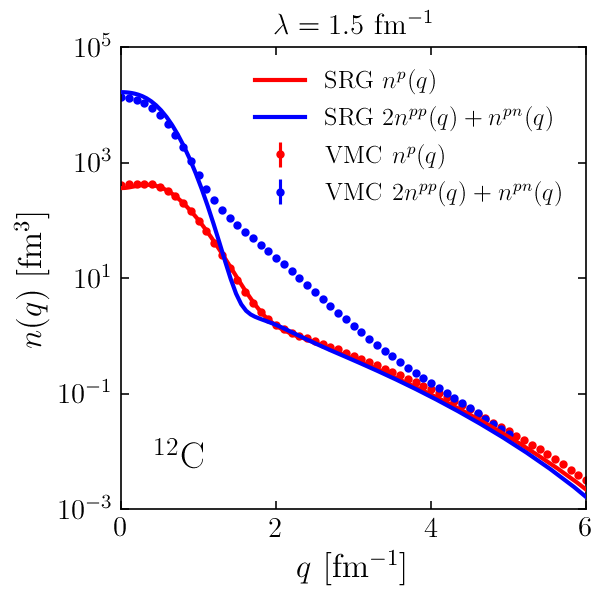

In [22]:
asymptotic_check('C12', 6, 1.5, save=True)

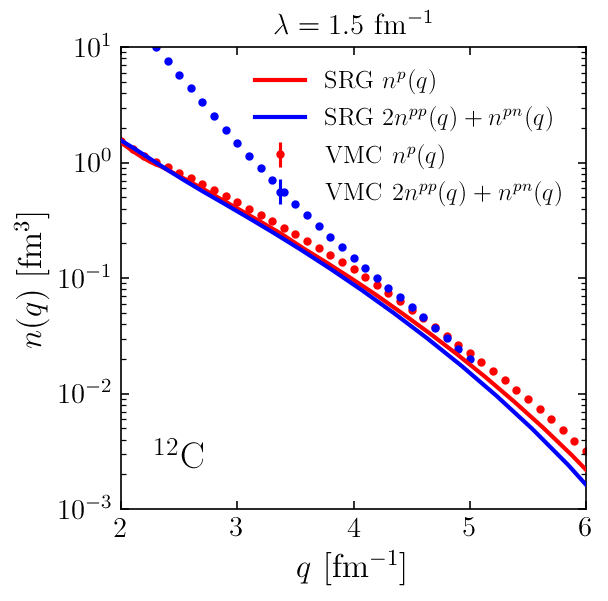

In [23]:
asymptotic_check('C12', 6, 1.5, x_limits=(2,6), y_limits=(1e-3,1e1), save=True)

## Determine scale $\lambda$

$$
\begin{align}
    \lambda &\approx \sqrt{\langle q^2 \rangle} \\
    &= \Bigl[ \int_0^\infty dq q^2 P^N_A(q) \Bigr]^{1/2} \\
    &= \Bigl[ \frac{1}{A} \int_0^\infty dq q^4 \bigl( n^p_A(q)+n^n_A(q) \bigr) \Bigr]^{1/2}
\end{align}
$$</br>

where $P^N_A(q) \equiv \frac{q^2}{A}\bigl( n^p_A(q)+n^n_A(q) \bigr)$ is the probability distribution of a nucleon having momentum $q$ and is evaluated using IPM single-nucleon momentum distributions.

In [ ]:
def compute_average_momentum(nucleus_name, A):
    """Computes the average momentum by evaluating \sqrt( < q^2 > )."""
    
    # Interaction and SRG arguments don't matter here
    kvnn = 6
    lamb = 1.5
    
    # Load data from file
    q_array, q_weights, _, _, n_proton_ipm_array, _, _, _, _ = (
        load_momentum_distribution(nucleus_name, 'proton', kvnn, lamb)
    )
    q_array, q_weights, _, _, n_neutron_ipm_array, _, _, _, _ = (
        load_momentum_distribution(nucleus_name, 'neutron', kvnn, lamb)
    )
    
    # Combine proton and neutron distributions
    n_ipm_array = (n_proton_ipm_array + n_neutron_ipm_array) / A
    
    # Compute q^2 average
    q2_average = 4*np.pi * np.sum(q_weights * q_array ** 4 * n_ipm_array)
    
    # TESTING
    # q2_average = 4*np.pi * np.sum(q_weights * q_array ** 2 * n_ipm_array)
    # return q2_average
    
    return np.sqrt(q2_average)

In [ ]:
nucleus_name, A = 'He4', 4
q_average = compute_average_momentum(nucleus_name, A)
print(f"{nucleus_name} average momentum = {q_average:.5f}.")

In [ ]:
nucleus_name, A = 'C12', 12
q_average = compute_average_momentum(nucleus_name, A)
print(f"{nucleus_name} average momentum = {q_average:.5f}.")

In [ ]:
nucleus_name, A = 'Ca48', 48
q_average = compute_average_momentum(nucleus_name, A)
print(f"{nucleus_name} average momentum = {q_average:.5f}.")

In [ ]:
# Try this with relative pair momentum distribution so that \lambda to q is 1-1